In [1]:
import import_ipynb

from IPython.display import display, Image, update_display, HTML
from tensorflow.keras.utils import plot_model
import user_ad_interaction
from poibin import PoiBin
import keras_tuner as kt
import tensorflow as tf
import adgorithm as adg
import adgorithm_htuner
import multiprocessing
import pandas as pd
import numpy as np
import threading
import warnings
import tools
import users
import yappi
import time

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [2]:
root_directories = ["ADS16_Benchmark_part1", "ADS16_Benchmark_part2"]
data = {}
profile = False
print_debug_messages = False

In [3]:
tuner = tools.HyperbandWithBatchSize(
    user_ad_interaction.create_model,
    objective=kt.Objective("val_rating_mae", direction="min"),
    max_epochs=100,
    factor=3,
    hyperband_iterations=5,
    directory="user_ad_interaction_model_logs/hypertraining",
    project_name="user_ad_interaction"
)
data["best_hps"]=tuner.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Reloading Oracle from existing project user_ad_interaction_model_logs/hypertraining\user_ad_interaction\oracle.json
INFO:tensorflow:Reloading Tuner from user_ad_interaction_model_logs/hypertraining\user_ad_interaction\tuner0.json


In [4]:
ad_ftrs, num_categories, real_user_ftrs, ratings = user_ad_interaction.load_user_and_ad_ftrs(root_directories)
user_pca_normal_params = users.approximate_normal_params(real_user_ftrs.T)

data["ad_ftrs"] = ad_ftrs
data["user_ftrs"] = real_user_ftrs
data["ratings"] = ratings

INFO:tensorflow:Reloading Oracle from existing project adgorithm_logs/hypertraining\adgorithm_htuning\oracle.json
INFO:tensorflow:Reloading Tuner from adgorithm_logs/hypertraining\adgorithm_htuning\tuner0.json
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 50, 25)]     0           []                               
                                                                                                  
 text_input_dropout (Dropout)   (None, 50, 25)       0           ['text_input[0][0]']             
                                                                                                  
 transformer_block (Transformer  (None, 50, 25)      13714       ['text_input_dropout[0][0]']     
 Block)                                                                         

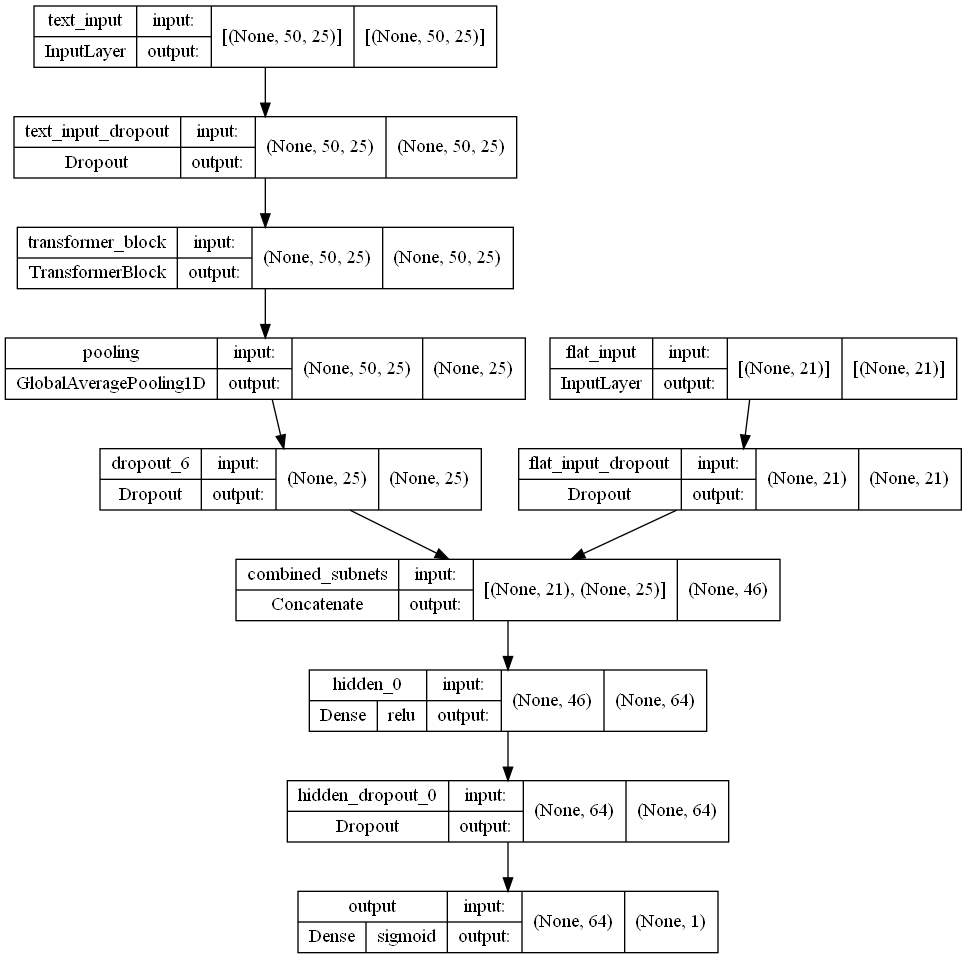

In [5]:
tuner = tools.HyperbandWithBatchSize(
    lambda hp: adgorithm_htuner.create_rl_model(hp),
    objective=kt.Objective("val_output_1_loss", direction="min"),
    max_epochs=100,
    factor=3,
    hyperband_iterations=5,
    directory="adgorithm_logs/hypertraining",
    project_name="adgorithm_htuning"
)
data["rl_best_hps"]=tuner.get_best_hyperparameters(num_trials=1)[0]

if __name__ == "__main__":
    model = adgorithm_htuner.create_rl_model(data["rl_best_hps"])
    model.summary()
    c = tools.ModelDisplayer()
    c.model = model
    c.on_epoch_end(0)

In [6]:
class IterationDataPrinter(threading.Thread):
    def __init__(self, num_sims, num_trainable_sims):
        super().__init__(daemon=True)
        self.iteration = -1
        self.killed = False
        self.num_sims = num_sims
        self.num_trainable_sims = num_trainable_sims
    
    @staticmethod
    def format_time(time):
        return f"{str(int(time//60)).rjust(2, '0')}:{str(int(time)%60).rjust(2, '0')}"
    
    @staticmethod
    def format_proportion(x, y):
        return f"[{x}/{y}] ({(100*((x/y) if y != 0 else 0)):.2f}%)"

    def new_iteration(self):
        now = time.time()
        self.num_sims_completed = 0
        self.num_trainable_sims_completed = 0
        self.iteration += 1
        self.last_iteration_time_string = "<b>Last iteration:</b> "
        if self.iteration > 0:
            self.last_iteration_time = now - self.iteration_start_time
            self.last_iteration_time_string += self.__class__.format_time(self.last_iteration_time)
        else:
            self.last_iteration_time_string += "n/a"
        self.iteration_start_time = now
    
    def sim_completed(self, is_trainable):
        if is_trainable:
            self.num_trainable_sims_completed += 1
        self.num_sims_completed += 1
    
    def kill(self):
        self.killed = True

    def run(self):
        while not self.killed:
            time.sleep(1)
            if self.iteration < 0:
                continue
            
            elapsed = time.time() - self.iteration_start_time
            elapsed_string = f"<b>This iteration:</b> {self.__class__.format_time(elapsed)}"
            if self.iteration > 0:
                elapsed_string += f" ({(100*(elapsed/self.last_iteration_time)):.2f}% of last iteration time)"
            lines = [
                f"<h1>Iteration {self.iteration}</h2>",
                self.last_iteration_time_string,
                elapsed_string,
                f"<b>Sims completed: {self.__class__.format_proportion(self.num_sims_completed, self.num_sims)}",
                f"<b>Trainable sims completed: {self.__class__.format_proportion(self.num_trainable_sims_completed, self.num_trainable_sims)}",
            ]
            update_display(HTML("<br/>".join(lines)), display_id="iteration_data")

In [7]:
def get_label(p_random):
    return (f"$\\epsilon_0={p_random[0]}$, $\\epsilon_1={p_random[1]}$" + (" (Random)" if p_random[0] >= 1 else "")) if p_random[0] >= 0 else "Cheater"

def plot_stat(ax, generator, min_size=0.01):
    all_ys = np.array([])
    mean_ys = []

    by_p = {}
    for sim_id in range(total_num_sims):
        ys = generator(sim_id)
        if np.all(np.isnan(ys)):
            continue
        p_random = (round(sim_p_randoms[sim_id][0], 5), round(sim_p_randoms[sim_id][1], 5))
        if p_random not in by_p:
            by_p[p_random] = []
        by_p[p_random].append(ys)
        ax.plot(ys, alpha=0.1, linestyle="dashed", color=colors[p_random])
        all_ys = np.concatenate([all_ys, ys])
    
    for p_random in sorted(by_p.keys()):
        if len(by_p[p_random]) == 0:
            m = np.array([])
        else:
            max_len = max(len(x) for x in by_p[p_random])
            for i, x in enumerate(by_p[p_random]):
                y = np.empty(max_len)
                y[:len(x)] = x
                y[len(x):] = np.nan
                by_p[p_random][i] = y
            m = np.mean(np.stack(by_p[p_random]), axis=0)
        ax.plot(m, linewidth=4, color=colors[p_random], label=get_label(p_random))
        if len(m[~np.isnan(m)]):
            mean_ys.append(m[~np.isnan(m)][-1])
    
    if len(by_p):
        ax.legend()

    all_non_nan_ys = all_ys[~np.isnan(all_ys)]
    y_max = max([np.percentile(all_non_nan_ys, 90) if len(all_non_nan_ys) else min_size, *mean_ys, min_size])
    dy = y_max * 0.1
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.set_ylim(top=y_max + dy, bottom=-dy)



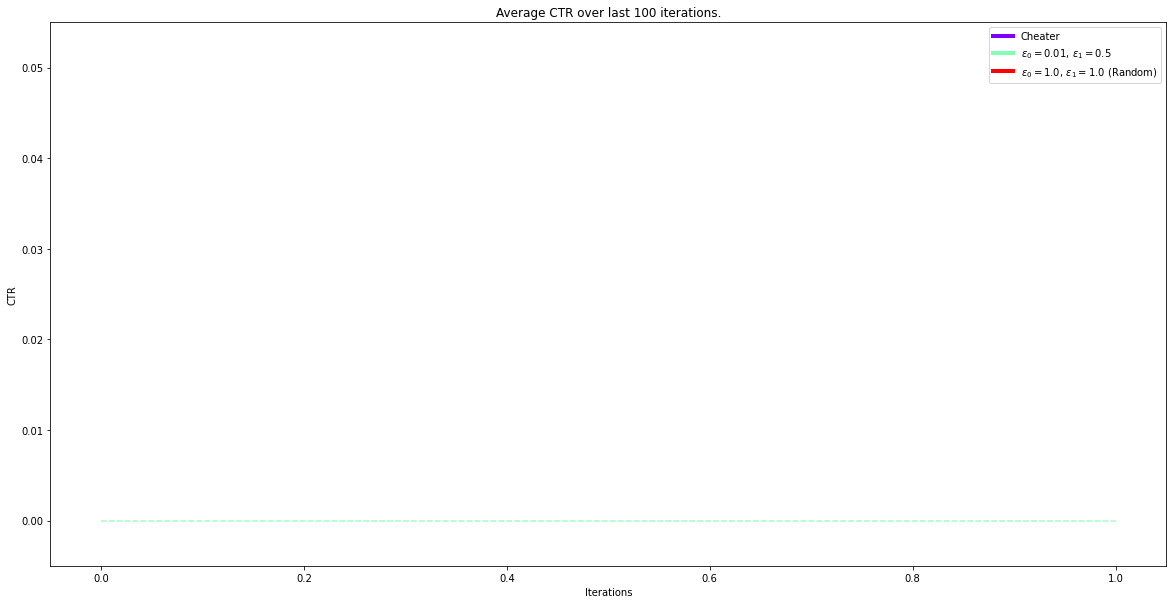

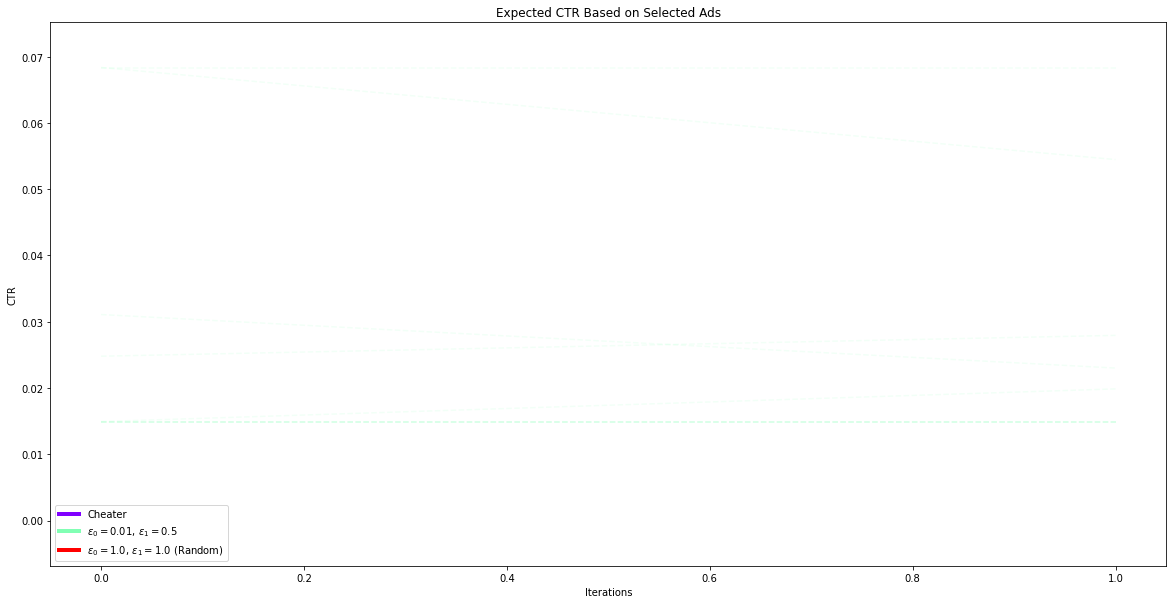

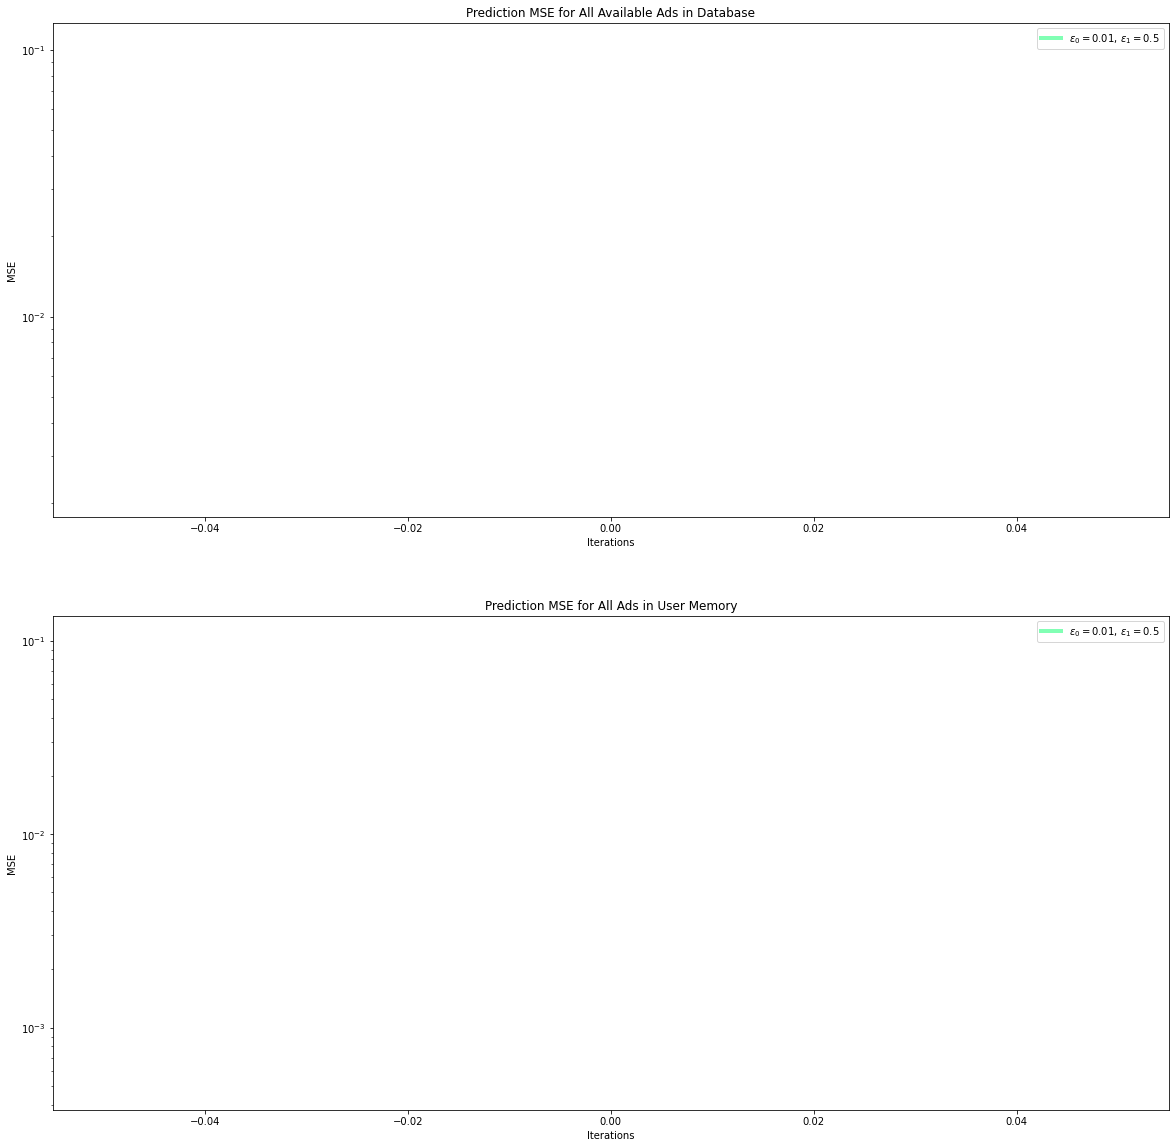

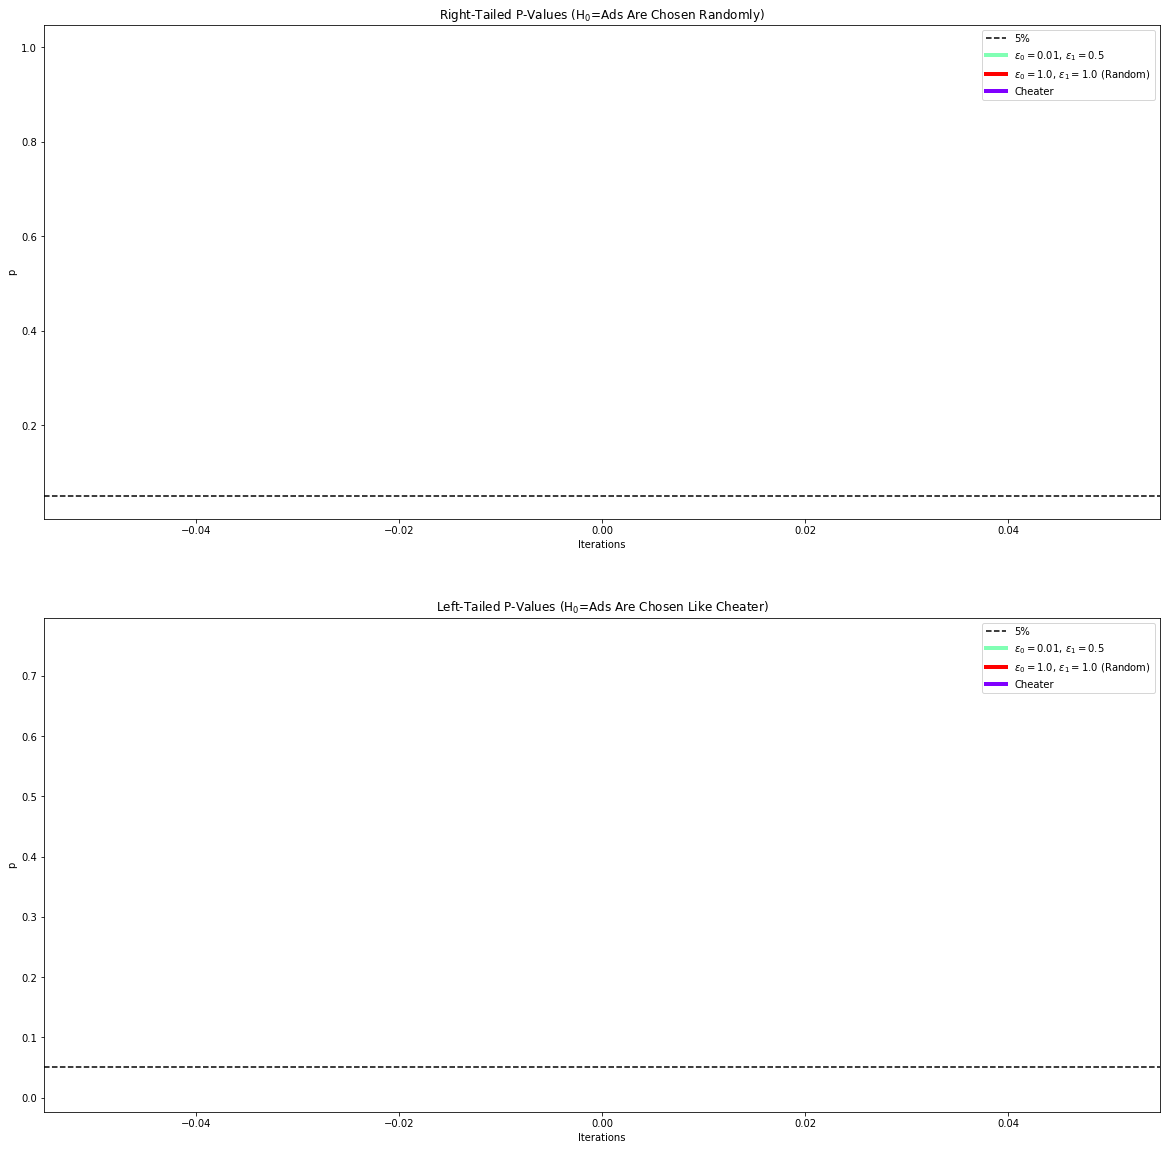

In [8]:
if __name__ == "__main__":
    q = adg.Queue()

    restart_queues = []
    kill_queues = []
    sim_p_randoms = []
    clicks = []
    ctr_dfs = []
    exp_ctrs = []
    accs = []
    significance_levels = {}
    significance_data_got = {}

    rolling_window_size = 100

    num_users_per_p = 100
    synthetic_user_ftrs = users.generate_synthetic_pca_ftrs(num_users_per_p, user_pca_normal_params)

    p_randoms = [
        (0.01, 0.50),
        (1.00, 1.00),
        (-1.0, -1.0)
    ]

    ps = sorted(p_randoms)
    colors = {}
    if len(ps) > 1:
        for i, v in enumerate(ps):
            colors[v] = cm.rainbow(i/(len(ps)-1))
    elif len(ps) == 1:
        colors[ps[0]] = cm.rainbow(1)


    display(HTML("<h1>Iteration Data</h1>"), display_id="iteration_data")
    display(HTML("<h1>CTR Graph</h1>"), display_id="ctr_graph")
    display(HTML("<h1>Expected CTR Graph</h1>"), display_id="exp_ctr_graph")
    display(HTML("<h1>Prediction Accuracy Graph</h1>"), display_id="pred_acc_graph")
    display(HTML("<h1>Significance Levels Graph</h1>"), display_id="sig_graph")

    total_num_sims = len(p_randoms) * num_users_per_p
    total_num_trainable_sims = len(list(filter(lambda x: 0 <= x[0] < 1, p_randoms))) * num_users_per_p

    idp = IterationDataPrinter(total_num_sims, total_num_trainable_sims)

    all_args = []
    
    i = 0
    for p_random in p_randoms:
        significance_levels[p_random] = ([], [])
        for j in range(num_users_per_p):
            sim_p_randoms.append(p_random)
            restart_queues.append(rq := adg.Queue())
            kill_queues.append(kq:= adg.Queue())
            clicks.append([])
            accs.append(([], []))
            exp_ctrs.append([])
            ctr_dfs.append(pd.Series(dtype="float32"))
            args = (i, q, synthetic_user_ftrs[j], p_random[0], p_random[1], rq, kq)
            all_args.append(args)
            i += 1
    
    if adg.use_multiprocessing:
        num_workers = 5
        threads_per_worker = np.zeros(num_workers, dtype=int) + (len(all_args)//num_workers)
        threads_per_worker[0] += len(all_args) - np.sum(threads_per_worker)
        assert np.sum(threads_per_worker) == len(all_args)
        i = 0
        for v in threads_per_worker[threads_per_worker > 0]:
            multiprocessing.Process(target=adg.run_n_sims, args=(data, all_args[i:i+v])).start()
            i += v
    else:
        adg.run_n_sims(data, all_args)


    try:
        if profile:
            yappi.start()
        idp.start()
        
        while True:
            for restart_queue in restart_queues:
                restart_queue.put(None)
            
            significance_level_data = {}
            for p_random in p_randoms:
                significance_level_data[p_random] = [[], [], 0]
                significance_data_got[p_random] = 0

            sims_to_complete_iteration = total_num_sims
            idp.new_iteration()
            while sims_to_complete_iteration > 0:
                event_type, *event = q.get()
                if event_type == adg.Simulation.EVENT_INTERACTION:
                    sim_id, did_click = event
                    clicks[sim_id].append(did_click)
                    if len(clicks[sim_id]) <= rolling_window_size:
                        ctr_dfs[sim_id] = pd.Series(clicks[sim_id]).expanding().mean()
                    else:
                        ctr_dfs[sim_id] = pd.Series(clicks[sim_id]).rolling(rolling_window_size).mean()
                    
                    fig, ax = plt.subplots(figsize=(20, 10))
                    fig.patch.set_facecolor("white")
                    
                    ax.set_xlabel("Iterations")
                    ax.set_ylabel("CTR")
                    ax.set_title(f"Average CTR over last {rolling_window_size} iterations.")
                    plot_stat(ax, lambda sim_id: ctr_dfs[sim_id].values)
            
                    update_display(fig, display_id="ctr_graph")
                    plt.close()
                
                if event_type == adg.Simulation.EVENT_EXP_CTR:
                    sim_id, exp_ctr = event
                    exp_ctrs[sim_id].append(exp_ctr)
                    
                    fig, ax = plt.subplots(figsize=(20, 10))
                    fig.patch.set_facecolor("white")
                    
                    ax.set_xlabel("Iterations")
                    ax.set_ylabel("CTR")
                    ax.set_title(f"Expected CTR Based on Selected Ads")
                    plot_stat(ax, lambda sim_id: np.array(exp_ctrs[sim_id]))
            
                    update_display(fig, display_id="exp_ctr_graph")
                    plt.close()

                
                elif event_type == adg.Simulation.EVENT_PREDICTION_ACCURACY:
                    sim_id, all_ads, ads_in_mem = event

                    accs[sim_id][0].append(all_ads)
                    accs[sim_id][1].append(ads_in_mem)

                    fig, axs = plt.subplots(2, figsize=(20, 20))
                    fig.patch.set_facecolor("white")

                    i=0

                    axs[i].set_title("Prediction MSE for All Available Ads in Database")
                    axs[i].set_xlabel("Iterations")
                    axs[i].set_ylabel("MSE")
                    axs[i].set_yscale('log')
                    plot_stat(axs[i], lambda sim_id: np.array(accs[sim_id][0]), min_size=0)
                    i += 1

                    axs[i].set_title("Prediction MSE for All Ads in User Memory")
                    axs[i].set_xlabel("Iterations")
                    axs[i].set_ylabel("MSE")
                    axs[i].set_yscale('log')
                    plot_stat(axs[i], lambda sim_id: np.array(accs[sim_id][1]), min_size=0)
                    i += 1

                    update_display(fig, display_id="pred_acc_graph")
                    plt.close()
                
                elif event_type == adg.Simulation.EVENT_SIGNIFICANCE_LEVEL_DATA:
                    sim_id, random_ctrs, cheater_ctrs, num_clicks = event
                    p_random = (round(sim_p_randoms[sim_id][0], 5), round(sim_p_randoms[sim_id][1], 5))
                    significance_level_data[p_random][0] += random_ctrs
                    significance_level_data[p_random][1] += cheater_ctrs
                    significance_level_data[p_random][2] += num_clicks

                    significance_data_got[p_random] += 1

                    if significance_data_got[p_random] == num_users_per_p:
                        sig_random = PoiBin(significance_level_data[p_random][0]).pval(int(significance_level_data[p_random][2]))
                        sig_cheater = PoiBin(significance_level_data[p_random][1]).cdf(int(significance_level_data[p_random][2]))
                        significance_levels[p_random][0].append(sig_random)
                        significance_levels[p_random][1].append(sig_cheater)

                        fig, axs = plt.subplots(2, figsize=(20, 20))
                        fig.patch.set_facecolor("white")

                        i=0

                        axs[i].set_title("Right-Tailed P-Values ($\mathregular{H_0}$=Ads Are Chosen Randomly)")
                        axs[i].set_xlabel("Iterations")
                        axs[i].set_ylabel("p")
                        axs[i].axhline(0.05, c="black", label="5%", linestyle="dashed")
                        for p in p_randoms:
                            axs[i].plot(significance_levels[p][0], linewidth=4, c=colors[p], label=get_label(p))
                        axs[i].legend()
                        i += 1

                        axs[i].set_title("Left-Tailed P-Values ($\mathregular{H_0}$=Ads Are Chosen Like Cheater)")
                        axs[i].set_xlabel("Iterations")
                        axs[i].set_ylabel("p")
                        axs[i].axhline(0.05, c="black", label="5%", linestyle="dashed")
                        for p in p_randoms:
                            axs[i].plot(significance_levels[p][1], linewidth=4, c=colors[p], label=get_label(p))
                        axs[i].legend()
                        i += 1
                        
                        update_display(fig, display_id="sig_graph")
                        plt.close()

                
                elif event_type == adg.Simulation.EVENT_ITERATION_COMPLETE:
                    sim_id, = event
                    sims_to_complete_iteration -= 1
                    idp.sim_completed(0 <= sim_p_randoms[sim_id][0] < 1)
                
                elif event_type == adg.Simulation.EVENT_DEBUG and print_debug_messages:
                    print(event)

    except KeyboardInterrupt:
        pass
    finally:
        if profile:
            yappi.stop()
        plt.close()
        for kill_queue in kill_queues:
            kill_queue.put(None)
        for restart_queue in restart_queues:
            kill_queue.put(False)
        idp.kill()

        if profile:
            threads = yappi.get_thread_stats()
            for thread in threads:
                print( "Function stats for (%s) (%d)" % (thread.name, thread.id))
                yappi.get_func_stats(ctx_id=thread.id).print_all()
